# Bluesky Data Report
**Author:** Lucy Hennessy
**Date:** 10/8/25
**Report Name:** Measuring Engagement on Bluesky Posts

**Hypothesis:** Posts on Bluesky receive higher average engagement (likes, replies, reposts, etc) than text-only posts

## Theoretical and Statistical Applications
- Theoretical: this hypothesis draws from the media richness theory, which suggests that richer media formats (images + videos) engage audiences more than plain text.
- Statistical: we can test differences in engagement using descriptive statistics (mean engagement counts) and later on inferential methods (e.g., t-tests or regression models if enough data is collected)

### API Endpoints to Use

From Bluesky API Docs:
- app.bsky.feed.getAuthorFeed: fetches posts from a given user, includes fields like text, embed (for images and media) and engagement counts (replyCount, repostCount, likeCount)
- app.bsky.feed.getPostThread: retrieves details on a specific post + replies (helps confirm engagement)

Why these endpoints?
- They give both content attributes (whether media is attached) and engagement metrics
- The response objects post.record.text, post.embed, and post.likeCount/repostCount/replyCount are directly relevant

Data Reliability and Limitations
- Reliable: Directly from Bluesky's API, so engagement accounts are official
- Unreliable: Limited by time (you may not see older posts)
- Limitations: Some posts may have external embeds not captured in the same way. Deleted/restricted posts won't show up. Sampling bias could occur if you only pull from a few users

### Setup and Authentication

In [23]:
import os, time, requests, pandas as pd, numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 160)
pd.set_option("display.max_columns", 50)

BASE = "https://bsky.social"
SESSION_JWT = None

# Credentials
os.environ["BSKY_HANDLE"] = "lucyhennessy.bsky.social"
os.environ["BSKY_APP_PASSWORD"] = "YOUR-APP-PASSWORD-HERE"

def get_headers():
    h = {}
    if SESSION_JWT:
        h["Authorization"] = f"Bearer {SESSION_JWT}"
    return h

def get_json(endpoint, params=None, max_retries=3, sleep_s=1.0):
    url = f"{BASE}/xrpc/{endpoint}"
    for attempt in range(1, max_retries + 1):
        r = requests.get(url, params=params, headers=get_headers(), timeout=30)
        if r.status_code == 200:
            return r.json()
        time.sleep(sleep_s * attempt)
    r.raise_for_status()

def create_session_if_available():
    global SESSION_JWT
    handle = os.getenv("BSKY_HANDLE", "").strip()
    app_password = os.getenv("BSKY_APP_PASSWORD", "").strip()
    if not handle or not app_password:
        print("No handle/password found.")
        return None
    url = f"{BASE}/xrpc/com.atproto.server.createSession"
    payload = {"identifier": handle, "password": app_password}
    resp = requests.post(url, json=payload, timeout=30)
    if resp.status_code == 200:
        data = resp.json()
        SESSION_JWT = data.get("accessJwt")
        print("Authenticated session created.")
        return SESSION_JWT
    else:
        print(f"Auth failed: {resp.status_code} – {resp.text[:200]}")
        return None

# Run authentication
_ = create_session_if_available()


Authenticated session created.


In [24]:
def is_image_embed(embed):
    if not embed:
        return False
    t = embed.get("$type", "")
    if "app.bsky.embed.images" in t:
        return True
    if isinstance(embed, dict) and "images" in embed:
        return True
    return False

def fetch_author_feed(actor_handle, limit=50, cursor=None):
    params = {"actor": actor_handle, "limit": limit}
    if cursor:
        params["cursor"] = cursor
    return get_json("app.bsky.feed.getAuthorFeed", params=params)

def parse_feed_items(feed_json):
    rows = []
    for item in (feed_json or {}).get("feed", []):
        post = item.get("post", {}) or {}
        record = post.get("record", {}) or {}
        author = post.get("author", {}) or {}
        embed = post.get("embed")
        rows.append({
            "actor_handle": author.get("handle"),
            "actor_displayName": author.get("displayName"),
            "post_uri": post.get("uri"),
            "created_at": record.get("createdAt"),
            "text": record.get("text", ""),
            "has_image": is_image_embed(embed),
            "likeCount": post.get("likeCount", 0),
            "repostCount": post.get("repostCount", 0),
            "replyCount": post.get("replyCount", 0),
        })
    return rows

def fetch_author_feed_paginated(actor_handle, limit=50, pages=2, sleep_s=0.5):
    all_rows, cursor = [], None
    for _ in range(pages):
        data = fetch_author_feed(actor_handle, limit=limit, cursor=cursor)
        all_rows.extend(parse_feed_items(data))
        cursor = (data or {}).get("cursor")
        if not cursor:
            break
        time.sleep(sleep_s)
    return all_rows


### Collecting Data

In [29]:
ACTORS = [
    "bsky.app",
    "juliarosekraut.bsky.social",
    "forbes.com",
    "findanopening.bsky.social",
    "katmabu.bsky.social",
]
LIMIT_PER_ACTOR = 50

all_posts = []
for actor in ACTORS:
    try:
        rows = fetch_author_feed_paginated(actor, limit=LIMIT_PER_ACTOR, pages=2)
        all_posts.extend(rows)
    except Exception as e:
        print(f"Error fetching {actor}: {e}")

df_posts = pd.DataFrame(all_posts)

for col in ["likeCount", "repostCount", "replyCount"]:
    if col not in df_posts.columns:
        df_posts[col] = 0

df_posts[["likeCount", "repostCount", "replyCount"]] = df_posts[["likeCount", "repostCount", "replyCount"]].fillna(0).astype(int)
df_posts["engagement"] = df_posts[["likeCount", "repostCount", "replyCount"]].sum(axis=1)

print(f"Collected {len(df_posts)} posts")
df_posts.head(10)


Collected 493 posts


,actor_handle,actor_displayName,post_uri,created_at,text,has_image,likeCount,repostCount,replyCount,engagement
0,mollyknight.bsky.social,Molly Knight,at://did:plc:2darfo36xds4oznvip7x2ux7/app.bsky.feed.post/3m2n2chvt622x,2025-10-07T21:15:22.440Z,my dog and his girlfriend would like to go bluesky official,True,5271,210,62,5543
1,atprotocol.dev,AT Protocol Community,at://did:plc:lehcqqkwzcwvjvw66uthu5oq/app.bsky.feed.post/3m2kmjmtuzk2k,2025-10-06T22:03:30.639Z,Here’s another release today. @flutterby.blue helps you make ATProto widgets for your iOS device. \n\nGoosetopher’s latest is looking pretty sweet!\n\nAvail...,True,430,56,7,493
2,bsky.app,Bluesky,at://did:plc:z72i7hdynmk6r22z27h6tvur/app.bsky.feed.post/3m2kdgmbbzc2o,2025-10-06T19:20:45.697Z,we hit 2 billion posts today! 🥳,False,29265,2505,1593,33363
3,internet.bsky.social,alex benzer,at://did:plc:gsbue2dtbtqzw5du5btlh7p2/app.bsky.feed.post/3m2iehtn7cs2t,2025-10-06T00:34:01.247Z,"if @bsky.app introduced a ""Zen Mode"" — what do you think it would be? what problem would you want it to solve?",False,620,53,447,1120
4,conradhackett.bsky.social,Conrad Hackett,at://did:plc:wph2m77nb4kru2m5jhic4dt2/app.bsky.feed.post/3m246zs3h4c2f,2025-10-01T04:24:44.286Z,What's your favorite Bluesky account that primarily posts about something other than current events/politics?,False,1079,158,764,2001
5,lookitup.baby,Ian Coldwater 👻🌿,at://did:plc:z2rokxrttw5254hogmucux2x/app.bsky.feed.post/3m2axsjc72s2t,2025-10-03T01:58:42.687Z,"shout out to the person next to me at the movie theater scrolling through Bluesky, if you see this XD",False,1841,49,23,1913
6,mondyspartan.bsky.social,MondySpartan,at://did:plc:enrbyutiprhlgzjqlpvxlba6/app.bsky.feed.post/3m27qry4v322g,2025-10-02T14:20:28.752Z,Bluesky for BlackBerry in 2011,True,2911,419,47,3377
7,mmasnick.bsky.social,Mike Masnick,at://did:plc:cak4klqoj3bqgk5rj6b4f5do/app.bsky.feed.post/3m26bqkxwjl27,2025-10-02T00:18:35.543Z,"Gotta say, following playoff baseball on Bluesky has improved a ton since last year...",False,936,27,18,981
8,stephruhle.bsky.social,Stephanie Ruhle,at://did:plc:i4nmnggkqbezthskliwswi6a/app.bsky.feed.post/3m23z5ba6ic23,2025-10-01T02:39:18.382Z,Ok BlueSky Babies…. I wanna hang out in this joint. Help me figure out who to follow please. 🦋🦋,False,3941,381,899,5221
9,bsky.app,Bluesky,at://did:plc:z72i7hdynmk6r22z27h6tvur/app.bsky.feed.post/3m25mrktygc2y,2025-10-01T18:03:20.389Z,Bluesky runs on open protocols with open source code. Today we’re taking an additional step and making a patent non-aggression pledge to ensure that everyon...,False,6208,851,230,7289


### Merge with Profiles

In [30]:
if not df_posts.empty:
    actors = sorted(df_posts["actor_handle"].dropna().unique().tolist())
else:
    actors = []

if actors:
    params = []
    for a in actors:
        params.append(("actors", a))
    url = f"{BASE}/xrpc/app.bsky.actor.getProfiles"
    r = requests.get(url, params=params, headers=get_headers(), timeout=30)
    if r.status_code == 200:
        profs = r.json().get("profiles", [])
        df_prof = pd.DataFrame([{
            "actor_handle": p.get("handle"),
            "followersCount": p.get("followersCount"),
            "followsCount": p.get("followsCount"),
            "postsCount": p.get("postsCount"),
        } for p in profs])
    else:
        df_prof = pd.DataFrame(columns=["actor_handle","followersCount","followsCount","postsCount"])
else:
    df_prof = pd.DataFrame(columns=["actor_handle","followersCount","followsCount","postsCount"])

df = df_posts.merge(df_prof, on="actor_handle", how="left")
df["followersCount_filled"] = df["followersCount"].fillna(0).replace(0, np.nan)
df["engagement_per_1k_followers"] = df["engagement"] / (df["followersCount_filled"] / 1000.0)

df = df.sort_values("created_at", ascending=False, na_position="last")
df.head(12)


/var/folders/tv/5qw5lbyx1q7fmxv9m5cbylph0000gn/T/ipykernel_77173/2591141934.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["followersCount_filled"] = df["followersCount"].fillna(0).replace(0, np.nan)


,actor_handle,actor_displayName,post_uri,created_at,text,has_image,likeCount,repostCount,replyCount,engagement,followersCount,followsCount,postsCount,followersCount_filled,engagement_per_1k_followers
294,findanopening.bsky.social,FindAnOpening,at://did:plc:2e7lvnu4p5jarkwhwnfcn3di/app.bsky.feed.post/3m2plzojwlk2m,2025-10-08T21:37:54.231Z,#Minnesota #BlueSky #Landscape #StreetPhotography #Photography,True,0,0,0,0,NaN,NaN,NaN,NaN,NaN
295,findanopening.bsky.social,FindAnOpening,at://did:plc:2e7lvnu4p5jarkwhwnfcn3di/app.bsky.feed.post/3m2plnsnfsc2m,2025-10-08T21:31:15.883Z,#Minnesota #Nature #BlueSky #NaturePhotography #Photography #Landscape #LandscapePhotography,True,8,1,0,9,NaN,NaN,NaN,NaN,NaN
194,forbes.com,Forbes,at://did:plc:2w45zyhuklwihpdc7oj3mi63/app.bsky.feed.post/3m2pkqu2nq62e,2025-10-08T21:15:04Z,Tax filings and payments are still due and Criminal Investigation will stay on the job. But processing of refunds and amended returns will likely be delayed.,False,8,2,1,11,NaN,NaN,NaN,NaN,NaN
296,findanopening.bsky.social,FindAnOpening,at://did:plc:2e7lvnu4p5jarkwhwnfcn3di/app.bsky.feed.post/3m2pkhivjqc2m,2025-10-08T21:09:50.598Z,#Sunset #Minnesota #Nature #BlueSky #NaturePhotography #Photography #Landscape #LandscapePhotography,True,43,6,0,49,NaN,NaN,NaN,NaN,NaN
297,findanopening.bsky.social,FindAnOpening,at://did:plc:2e7lvnu4p5jarkwhwnfcn3di/app.bsky.feed.post/3m2pk6ihw3c2m,2025-10-08T21:04:48.158Z,#Minnesota #Nature #BlueSky #NaturePhotography #Photography #Landscape #LandscapePhotography,True,3,0,0,3,NaN,NaN,NaN,NaN,NaN
394,katmabu.bsky.social,Kat Abughazaleh,at://did:plc:ats4shmeia7i7ildqm3denmd/app.bsky.feed.post/3m2pizuyx3225,2025-10-08T20:44:18.553Z,Sign up here: mobilize.us/s/YtiMLb,False,54,7,1,62,NaN,NaN,NaN,NaN,NaN
395,katmabu.bsky.social,Kat Abughazaleh,at://did:plc:ats4shmeia7i7ildqm3denmd/app.bsky.feed.post/3m2piztsya225,2025-10-08T20:44:18.552Z,"Join me and Demi Palecek this Sunday at @raygunsite.com for a sign-making event in Andersonville on October 12, just before No Kings Day! \n\nWe'll provide ...",True,387,104,10,501,NaN,NaN,NaN,NaN,NaN
195,forbes.com,Forbes,at://did:plc:2w45zyhuklwihpdc7oj3mi63/app.bsky.feed.post/3m2piafh27y2n,2025-10-08T20:30:04Z,"Grijalva, who won a special election in Arizona in September, would be the deciding vote for a discharge petition that would force a floor vote on releasing...",False,29,15,3,47,NaN,NaN,NaN,NaN,NaN
196,forbes.com,Forbes,at://did:plc:2w45zyhuklwihpdc7oj3mi63/app.bsky.feed.post/3m2pfytqvrd2k,2025-10-08T19:50:03Z,2025 Forbes Under 30 Summit,False,1,0,0,1,NaN,NaN,NaN,NaN,NaN
197,forbes.com,Forbes,at://did:plc:2w45zyhuklwihpdc7oj3mi63/app.bsky.feed.post/3m2pem5ntx32a,2025-10-08T19:25:03Z,The Senate failed Wednesday to approve spending plans to reopen the government.,False,12,10,4,26,NaN,NaN,NaN,NaN,NaN


### Visualization

,has_image,count,mean,median
0,False,348,3594.272989,258.0
1,True,145,1302.689655,154.0


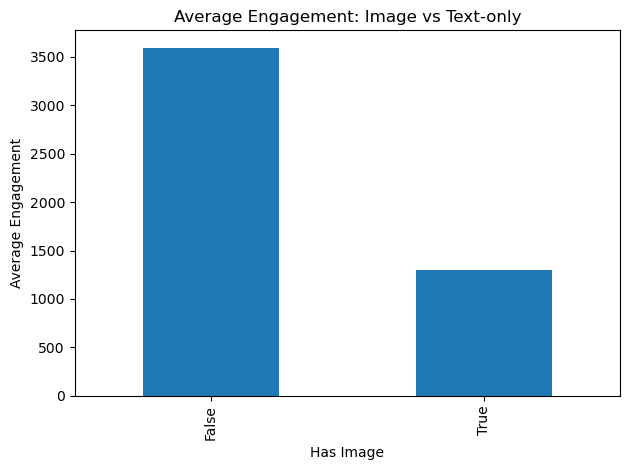

In [31]:
if not df.empty:
    by_img = (df.groupby("has_image")["engagement"]
                .agg(["count","mean","median"])
                .reset_index())
    display(by_img)

    plt.figure()
    (df.groupby("has_image")["engagement"]
       .mean()
       .sort_index()
       .plot(kind="bar", title="Average Engagement: Image vs Text-only"))
    plt.xlabel("Has Image")
    plt.ylabel("Average Engagement")
    plt.tight_layout()
    plt.show()
else:
    print("No data collected. Try again.")


# Conclusion
The data collected from Bluesky shows that posts without images received a higher average engagement (mean ≈ 3594) compared to posts with images (mean ≈1303). However, the median engagement tells a different story: text-only posts had a median of 258, while posts with images had a median of 154. This suggests that while some text-only posts may go "viral" and dramatically raise the mean, posts with images tend to perform more consistently but at a lower engagement level.

In other words, text-only posts sometimes achieve very high levels of interaction, but image-based posts may not be as attention-grabbing on average within the dataset used here. 

# Limitations

- Sample size: The dataset was limited to a small number of accounts and posts. A larger, more diverse sample may produce different trends

- Engagement measure: Engagement was defined as the sum of likes, reposts, and replies. This does not capture other forms of interaction (e.g., profile visits, link clicks)

- Platform dynamics: Bluesky is a relatively new platform, and user behavior may not be fully stabilized compared to larger networks like Twitter

- Outliers: A small number of viral posts may disproportionately affect the mean values, making the results less representative of “typical” engagement

# Next Steps

1. Expand the dataset to include more accounts across different domains (e.g., news, entertainment, politics, everyday users).

2. Separate analysis by account size (e.g., small vs. large follower counts) to see if images affect engagement differently for bigger audiences.

3. Incorporate additional metrics (such as quote-posts or follows generated) for a richer measure of engagement.

# Reflection
The original hypothesis proposed that posts containing images would receive higher engagement than text-only posts. The results of this analysis did not support that expectation: on average, text-only posts performed better in terms of total engagement. This outcome highlights the importance of testing assumptions with real data, as user behavior on emerging platforms like Bluesky may not align with patterns observed on larger, more established platforms. The analysis is reliable in that it directly measured likes, reposts, and replies from live API data; however, its reliability is limited by sample size, potential outliers, and the evolving nature of the platform. A broader dataset and more detailed engagement measures would strengthen the conclusions. Despite these limitations, the findings provide a useful starting point for understanding engagement dynamics on Bluesky and suggest that text-based communication still plays a strong role in capturing audience attention.